In [4]:
from synthcity.metrics.eval import Metrics
import pandas as pd
def synthcity_evaluate(real_path,
                       syn_path,
                       result_name=None,
                       real_size = None,
                       syn_size = None):
    real_data = pd.read_csv(real_path)
    syn_data = pd.read_csv(syn_path)
    
    if real_size and real_size < len(real_data):
        real_data = real_data.sample(n=real_size, random_state=42)  # Adjust random_state as desired for reproducibility

    if syn_size and syn_size < len(syn_data):
        syn_data = syn_data.sample(n=syn_size, random_state=42)
    
    metrics = {
        'sanity': ['data_mismatch', 'nearest_syn_neighbor_distance', 'close_values_probability'],
        'stats': ['jensenshannon_dist', 'feature_corr', 'ks_test', 'max_mean_discrepancy', 'prdc', 'alpha_precision'],
        'performance': ['linear_model', 'mlp', 'xgb'],
        # 'detection': ['detection_xgb', 'detection_mlp', 'detection_linear'],
        # 'privacy': ['delta-presence', 'k-anonymization', 'k-map', 'distinct l-diversity', 'identifiability_score']
    }
    
    synthcity_result = Metrics.evaluate(real_data, syn_data, metrics=metrics)
    if result_name:
        synthcity_result.to_csv(result_name)
    return synthcity_result
    
    
def compare(real_file_name, no_water_mark_file_name, with_water_mark_file_name, sample_size=200, round_to=None):
    samples_dir = "/Users/minhkau/Documents/TUDelft/Year 3/RP/Code/tabular-gpt/samples/"
    real_path = samples_dir + real_file_name
    synth_no_watermark_path = samples_dir + no_water_mark_file_name
    synth_with_watermark_path = samples_dir + with_water_mark_file_name
    
    
    real_df = synthcity_evaluate(real_path, real_path, real_size=sample_size, syn_size=sample_size)[["min"]]
    no_water_mark_df = synthcity_evaluate(real_path, synth_no_watermark_path, real_size=sample_size, syn_size=sample_size)[["min"]]
    with_watermark_df = synthcity_evaluate(real_path, synth_with_watermark_path, real_size=sample_size, syn_size=sample_size)[["min", "direction"]]
    merge_result = real_df.join(no_water_mark_df, lsuffix='_real', rsuffix='_no_watermark')
    merge_result_final = merge_result.join(with_watermark_df)
    
    merge_result_final.columns = ["Real Data", "No-Watermark", "With-Watermark", "Direction"]
    if round_to:
        merge_result_final = merge_result_final.round(round_to)
    return merge_result_final

"""
Utilities
"""

def get_detector(gamma, delta):
    tokenizer = transformers.AutoTokenizer.from_pretrained('distilgpt2', add_prefix_space=True)
    tokenizer.pad_token_id = tokenizer.eos_token_id
    tokenizer.pad_token = tokenizer.eos_token
    great_watermark_processor = GreatWatermarkLogitProcessor(tokenizer=tokenizer,
                                                             device="cpu",
                                                             vocab=list(tokenizer.get_vocab().values()),
                                                             gamma=gamma,
                                                             delta=delta)
    great_watermark_detector = GreatWatermarkDetector(great_watermark_processor)
    return great_watermark_detector
    
    
import glob
import re
import os
def get_filenames_from_model(model_name, common_size, gamma, delta):
    # Define the search pattern, allowing any string for sample size part
    search_pattern_non_watermark = f"{model_name}_*_non-watermark.csv"
    search_pattern_watermark = f"{model_name}_*_with-watermark_gamma-{gamma}_delta-{delta}.csv"

    # Use glob to get all files matching the search
    directory = "/Users/minhkau/Documents/TUDelft/Year 3/RP/Code/tabular-gpt/samples"
    files_non_watermark = glob.glob(search_pattern_non_watermark, root_dir=directory)
    files_watermark = glob.glob(search_pattern_watermark, root_dir=directory)

    # Regular expressions to extract sample size from filenames
    regex_pattern_non_watermark = re.compile(rf"{model_name}_(\d+)_non-watermark.csv")
    regex_pattern_watermark = re.compile(rf"{model_name}_(\d+)_with-watermark_gamma-{gamma}_delta-{delta}.csv")

    largest_sample_size_non_watermark = -1
    largest_sample_size_with_watermark = -1
    largest_file_non_watermark = None
    largest_file_with_watermark = None
    # Iterate over the matching files and extract sample size
    for file in files_non_watermark:
        match = regex_pattern_non_watermark.match(os.path.basename(file))
        if match:
            sample_size = int(match.group(1))
            if sample_size == common_size:
                largest_file_non_watermark = file
                break
            if sample_size > largest_sample_size_non_watermark:
                largest_sample_size_non_watermark = sample_size
                largest_file_non_watermark = file

    for file in files_watermark:
        match = regex_pattern_watermark.match(os.path.basename(file))
        if match:
            sample_size = int(match.group(1))
            if sample_size == common_size:
                largest_file_with_watermark = file
                break
            if sample_size > largest_sample_size_with_watermark:
                largest_sample_size_with_watermark = sample_size
                largest_file_with_watermark = file

    return f"{model_name}.csv", largest_file_non_watermark, largest_file_with_watermark

"""
Compute one single score for data quality
Compute the average z-score of synthetic data (over a number of samples)
"""
from watermarking.great_watermark import GreatWatermarkLogitProcessor, GreatWatermarkDetector
import transformers

def average_data_quality(real_file_name, no_water_mark_file_name, with_water_mark_file_name, sample_size=1000):
    """
    Compute the average quality of synthetic data, with watermarks and without watermarks
    The scores are divided into 3 groups: resemblance, ML utility and discriminatory 
    Args:
        real_file_name: 
        no_water_mark_file_name: 
        with_water_mark_file_name: 
        size: default to 1000 rows
    """

    scores = compare(
        real_file_name = real_file_name,
        no_water_mark_file_name = no_water_mark_file_name,
        with_water_mark_file_name = with_water_mark_file_name,
        sample_size = sample_size
    )
    
    for col in ['Real Data', 'No-Watermark', 'With-Watermark']:
        scores[col] = scores.apply(lambda row: 1 - row[col] if row['Direction'] == 'minimize' else row[col], axis=1)
    
    scores =  scores.drop('Direction', axis=1)
    scores = scores.astype(float)

    # Resemblance
    resemblance_metrics = ['stats.jensenshannon_dist.marginal',
                           'stats.ks_test.marginal',
                           'stats.max_mean_discrepancy.joint',
               'stats.prdc.precision', 'stats.prdc.recall', 'stats.prdc.density', 'stats.prdc.coverage',
               'stats.alpha_precision.delta_precision_alpha_OC', 'stats.alpha_precision.delta_coverage_beta_OC',
               'stats.alpha_precision.authenticity_OC', 'stats.alpha_precision.delta_precision_alpha_naive',
               'stats.alpha_precision.delta_coverage_beta_naive', 'stats.alpha_precision.authenticity_naive'],
    resemblance_df = scores.loc[resemblance_metrics]  
    resemblance_scores = resemblance_df[['No-Watermark', 'With-Watermark']].mean()
    
    # ML utility metrics
    linear_performance = scores.loc['performance.linear_model.syn_id'] / scores.loc['performance.linear_model.gt']
    mlp_performance = scores.loc['performance.mlp.syn_id'] / scores.loc['performance.mlp.gt']
    xgb_performance = scores.loc['performance.xgb.syn_id'] / scores.loc['performance.xgb.gt']
    ml_performance_scores = (linear_performance + mlp_performance + xgb_performance).drop("Real Data") / 3

    final_scores = {
        "resemblance": resemblance_scores,
        "ml_performance": ml_performance_scores,
        "avg_final_score": (resemblance_scores + ml_performance_scores) / 2
    }
    return final_scores
    
def average_zscore(sample_name, gamma, delta, num_tokens, num_samples = 50, use_weighted_z_score = False):
    """
    Compute the average z_score over a number of random samples from the synthesized data
    """
    samples_dir = "/Users/minhkau/Documents/TUDelft/Year 3/RP/Code/tabular-gpt/samples/"
    sample_df = pd.read_csv(samples_dir + sample_name)
    
    tokenizer = transformers.AutoTokenizer.from_pretrained('distilgpt2', add_prefix_space=True)
    tokenizer.pad_token_id = tokenizer.eos_token_id
    tokenizer.pad_token = tokenizer.eos_token
    great_watermark_processor = GreatWatermarkLogitProcessor(tokenizer=tokenizer,
                                                             device="cpu",
                                                             vocab=list(tokenizer.get_vocab().values()),
                                                             gamma=gamma,
                                                             delta=delta)
    great_watermark_detector = GreatWatermarkDetector(great_watermark_processor)
    
    z_scores = []
    
    for i in range(num_samples):
        if use_weighted_z_score:
            z_scores.append(great_watermark_detector.detect(
            sample_df,
            total_tokens_limit=num_tokens,
            random_state=i,
            # included_columns=["fnlwgt", "occupation"]
            )['weighted_z_score'])
        else:
            z_scores.append(great_watermark_detector.detect(
                sample_df,
                total_tokens_limit=num_tokens,
                random_state=i,
                # included_columns=["fnlwgt", "occupation"]
            )['z_score'])
    return sum(z_scores) / len(z_scores)

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP. To fix this, you can set the environment
                  variable OMP_PATH to the location of the header before importing keopscore or pykeops,
                  e.g. using os.environ: import os; os.environ['OMP_PATH'] = '/path/to/omp/header'
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


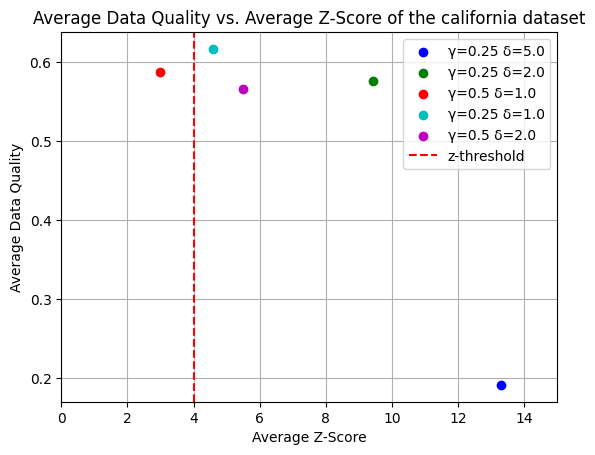

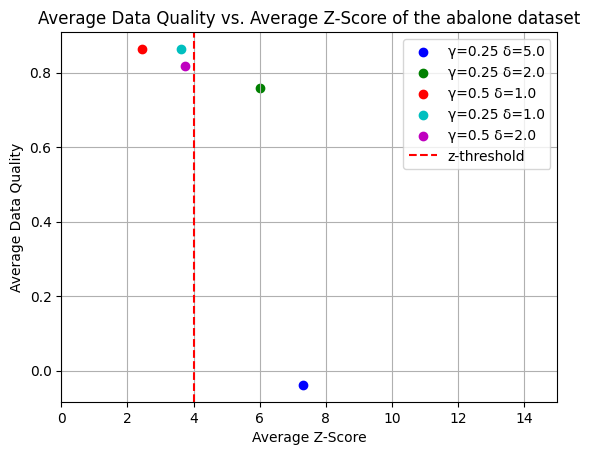

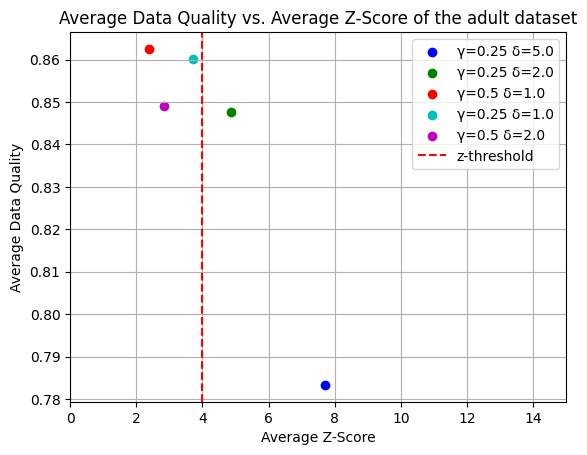

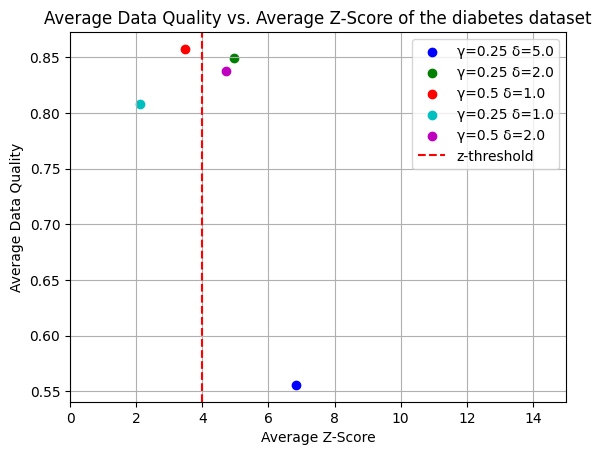

In [4]:
"""
Trade-off between strength (z-score) and data quality (using synthcity)
"""
import matplotlib.pyplot as plt

def plot_data_quality_vs_z_score(model_name, gamma_delta_pairs, sample_size, num_tokens, z_threshold = None):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Define colors for each point

    for i, (gamma, delta) in enumerate(gamma_delta_pairs):
        real_file_name, no_water_mark_file_name , with_water_mark_file_name = get_filenames_from_model(model_name, common_size=1000, gamma=gamma, delta=delta)
    
        average_data_quality_result = average_data_quality(real_file_name, no_water_mark_file_name, with_water_mark_file_name, sample_size)
        avg_qual = average_data_quality_result["avg_final_score"]["With-Watermark"]
        
        avg_z = average_zscore(with_water_mark_file_name, gamma, delta, num_tokens)
        plt.scatter(avg_z, avg_qual, c=colors[i], label=f'γ={gamma} δ={delta}')  # Use different colors for each point
    
    # plt.scatter(average_zscores, average_data_qualities, c=colors[:len(average_zscores)])  # Use different colors for each point
    plt.xlabel('Average Z-Score')
    plt.ylabel('Average Data Quality')
    plt.title(f'Average Data Quality vs. Average Z-Score of the {model_name} dataset')
    plt.xlim(0, 15)
    
    if z_threshold:
        plt.axvline(x=z_threshold, color='red', linestyle='--', label='z-threshold')  # Add vertical red line

    plt.legend()
    plt.grid(True)
    plt.show()

gamma_delta_pairs = [(0.25, 5.0), (0.25, 2.0), (0.5, 1.0), (0.25, 1.0), (0.5, 2.0)]
for model_name in ["california", "abalone", "adult", "diabetes"]:
    plot_data_quality_vs_z_score(
        model_name=model_name,
        gamma_delta_pairs=gamma_delta_pairs,
        sample_size=1000,
        num_tokens=200,
        z_threshold=4.0
    )


In [12]:
"""
Compute ROC and AOC
"""
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def compute_roc_auc(model_names, gamma_delta_pairs, num_samples_per_class, num_tokens_per_sample, plot_distribution=False, included_columns=None, softmax_temp=2.0, linear_scale=1.0):
    tokenizer = transformers.AutoTokenizer.from_pretrained('distilgpt2', add_prefix_space=True)
    tokenizer.pad_token_id = tokenizer.eos_token_id
    tokenizer.pad_token = tokenizer.eos_token
    
    results = []
    weighted_results = []
    
    for gamma, delta in gamma_delta_pairs:
        great_watermark_detector = get_detector(gamma, delta)
        real_scores = []
        gen_scores = []
        weighted_real_scores = []
        weighted_gen_scores = []
        for model_name in model_names:
            samples_dir = "/Users/minhkau/Documents/TUDelft/Year 3/RP/Code/tabular-gpt/samples/"
            real_name, _, syn_name = get_filenames_from_model(model_name, 1000, gamma, delta)
            real_df = pd.read_csv(samples_dir + real_name)
            syn_df = pd.read_csv(samples_dir + syn_name)
            for i in range(int(num_samples_per_class / len(model_names))):
                real_result = great_watermark_detector.detect(real_df, total_tokens_limit=num_tokens_per_sample, random_state=i, included_columns=included_columns, softmax_temperature=softmax_temp, linear_scale=linear_scale)
                gen_result = great_watermark_detector.detect(syn_df, total_tokens_limit=num_tokens_per_sample, random_state=i, included_columns=included_columns, softmax_temperature=softmax_temp, linear_scale=linear_scale)
                real_scores.append(real_result['z_score'])
                gen_scores.append(gen_result['z_score'])  
                weighted_real_scores.append(real_result['weighted_z_score'])
                weighted_gen_scores.append(gen_result['weighted_z_score'])
        
        # Compute roc auc 
        y_true = np.concatenate([np.zeros(len(real_scores)), np.ones(len(gen_scores))])
        y_scores = np.concatenate([real_scores, gen_scores])
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        results.append((gamma, delta, fpr, tpr, roc_auc))
        
        y_true_weighted = np.concatenate([np.zeros(len(weighted_real_scores)), np.ones(len(weighted_gen_scores))])
        y_scores_weighted = np.concatenate([weighted_real_scores, weighted_gen_scores])
        fpr_weighted, tpr_weighted, thresholds_weighted = roc_curve(y_true_weighted, y_scores_weighted)
        roc_auc_weighted = auc(fpr_weighted, tpr_weighted)
        weighted_results.append((gamma, delta, fpr_weighted, tpr_weighted, roc_auc_weighted))
    
        if plot_distribution:
            plot_z_score_distribution(real_scores, gen_scores, gamma, delta, weighted_real_scores, weighted_gen_scores)
    return {'non_weighted_results': results, "weighted_results": weighted_results}

def plot_roc_curves(results, weighted_results=None):
    if weighted_results:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    else:
        fig, axes = plt.subplots(1, 1, figsize=(8, 6))
        axes = [axes]  # Make it iterable

    # Plot the primary ROC curves on the first subplot
    axes[0].set_title('ROC Curves for Different Gamma and Delta Values')
    lw = 2
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Define colors for each line

    for i, (gamma, delta, fpr, tpr, roc_auc) in enumerate(results):
        axes[0].plot(fpr, tpr, lw=lw, label=f'γ={gamma} δ={delta} area = {roc_auc:.3f}', c=colors[i % len(colors)])
    
    axes[0].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate', fontsize=14)
    axes[0].set_ylabel('True Positive Rate', fontsize=14)
    axes[0].legend(loc="lower right", fontsize=12)

    # Plot the weighted ROC curves on the second subplot if weighted_results is provided
    if weighted_results:
        axes[1].set_title('Weighted ROC Curves for Different Gamma and Delta Values')
        for i, (gamma, delta, fpr, tpr, roc_auc) in enumerate(weighted_results):
            axes[1].plot(fpr, tpr, lw=lw, label=f'Weighted γ={gamma} δ={delta} area = {roc_auc:.3f}', c=colors[i % len(colors)])
        
        axes[1].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.05])
        axes[1].set_xlabel('False Positive Rate', fontsize=14)
        axes[1].set_ylabel('True Positive Rate', fontsize=14)
        axes[1].legend(loc="lower right", fontsize=12)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()


def plot_z_score_distribution(real_scores, gen_scores, gamma, delta, weighted_real_scores=None, weighted_gen_scores=None):
    # fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot the first set of kernel density plots on the first subplot
    sns.kdeplot(real_scores, label='Real', shade=True)
    sns.kdeplot(gen_scores, label='Synthetic', shade=True)
    if weighted_real_scores and weighted_gen_scores:
        sns.kdeplot(weighted_real_scores, label='Weighted Real', shade=True)
        sns.kdeplot(weighted_gen_scores, label='Weighted Synthetic', shade=True)
    
    plt.xlim(-20, 20)
    plt.ylim(0, 0.5)
    plt.xlabel('z-scores', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title(f'Distribution of z-scores of gamma={gamma} and delta={delta}', fontsize=14)
    plt.legend()
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Show the plot
    plt.show()

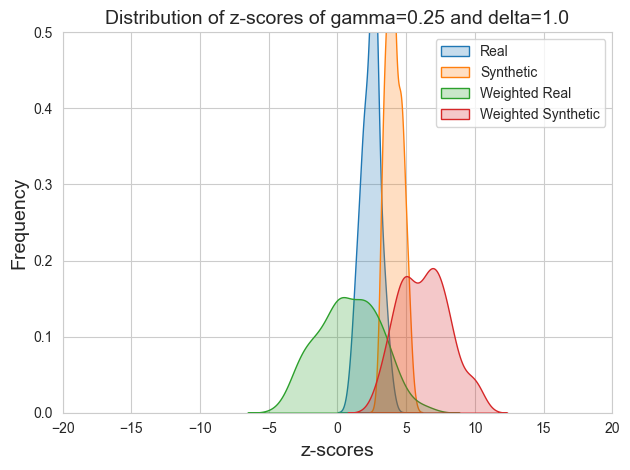

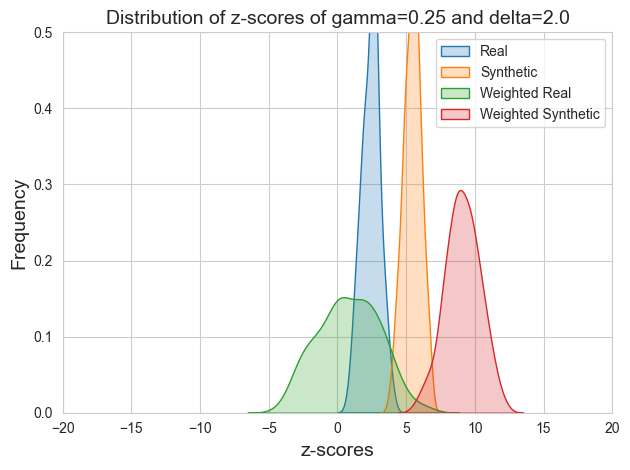

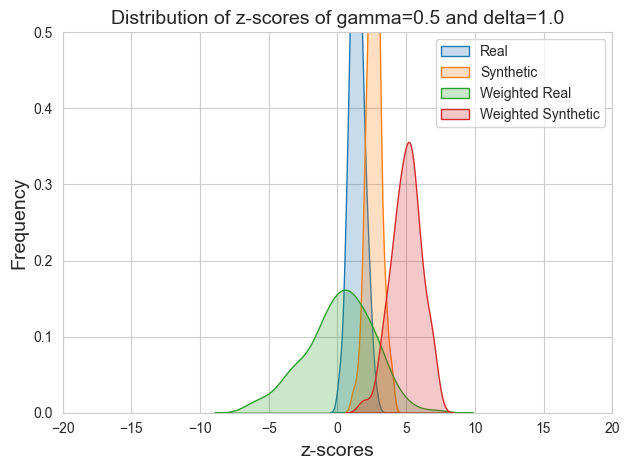

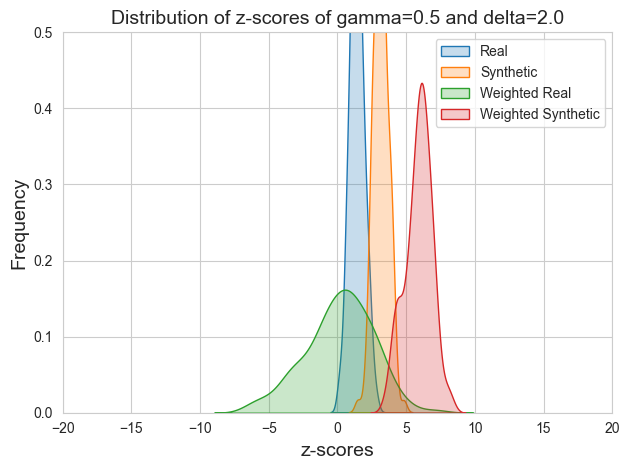

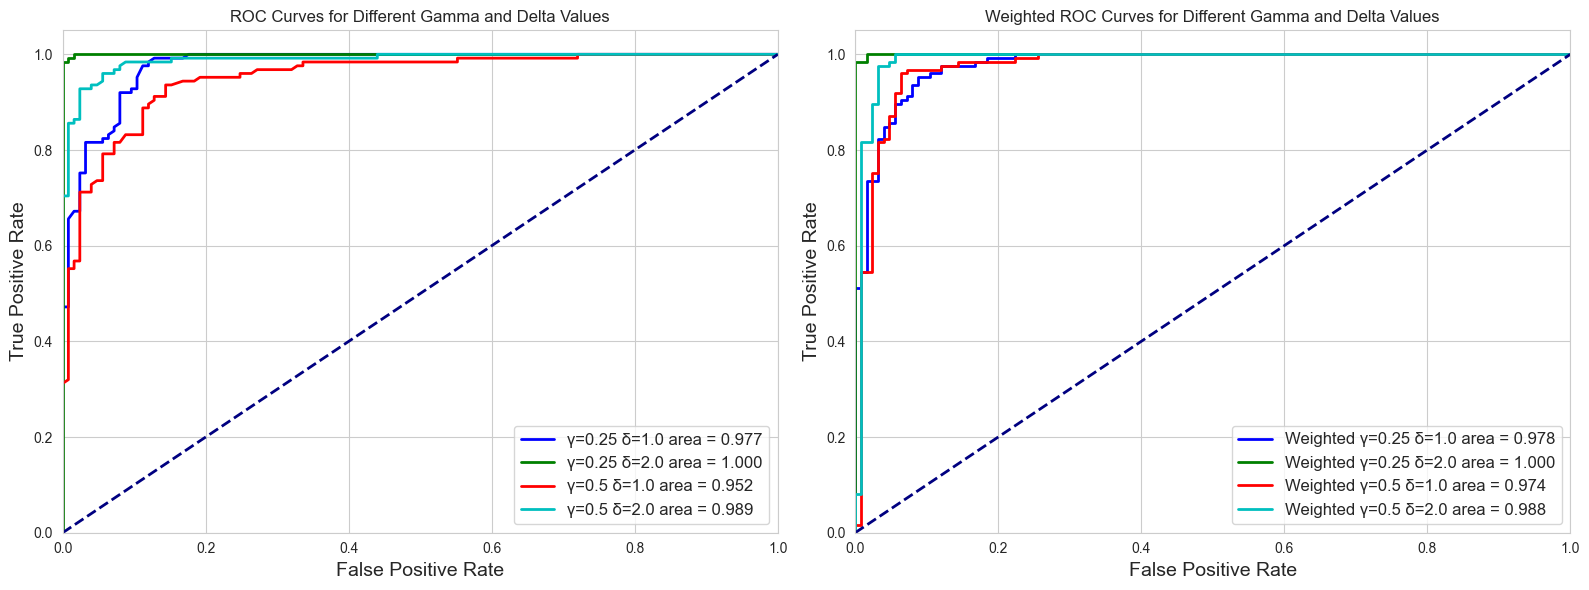

In [41]:
gamma_delta_pairs = [(0.25, 1.0), (0.25, 2.0),(0.5, 1.0), (0.5, 2.0)]


results = compute_roc_auc(
    ["adult"],
    gamma_delta_pairs=gamma_delta_pairs,
    num_samples_per_class=125, 
    num_tokens_per_sample=250,
    plot_distribution=True,
    softmax_temp=4.0,
)

# Plot all ROC curves
plot_roc_curves(results["non_weighted_results"], results["weighted_results"])

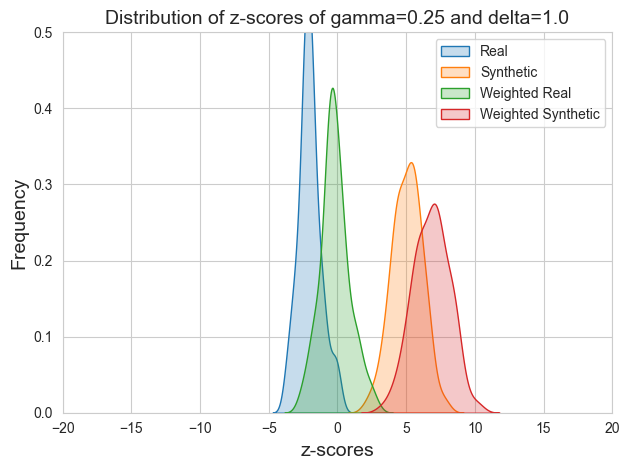

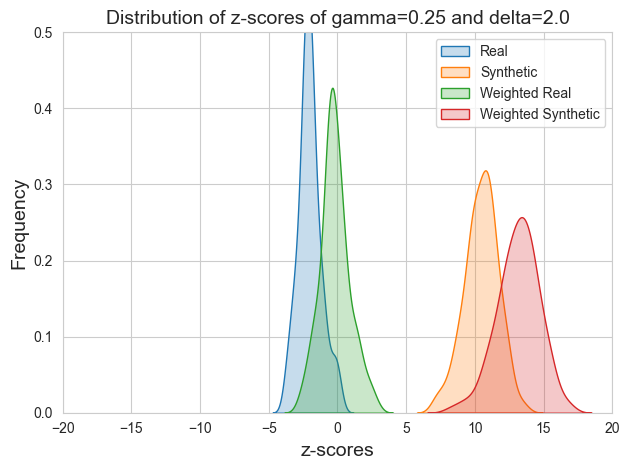

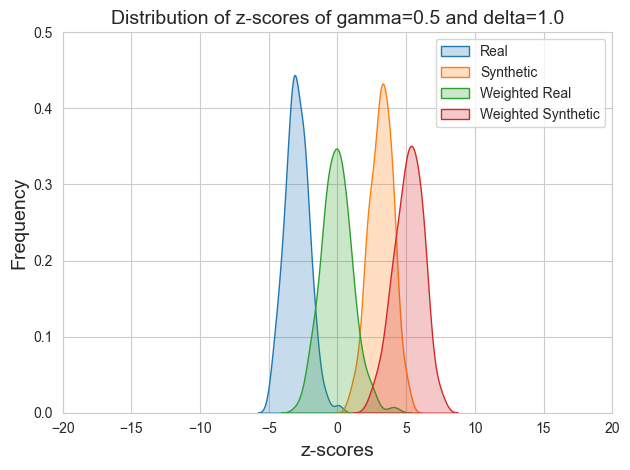

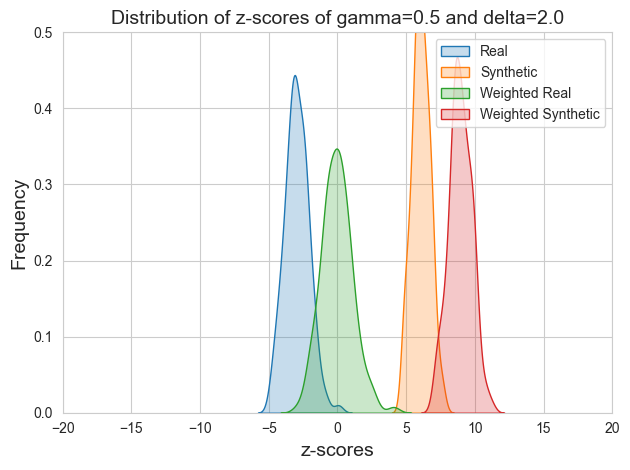

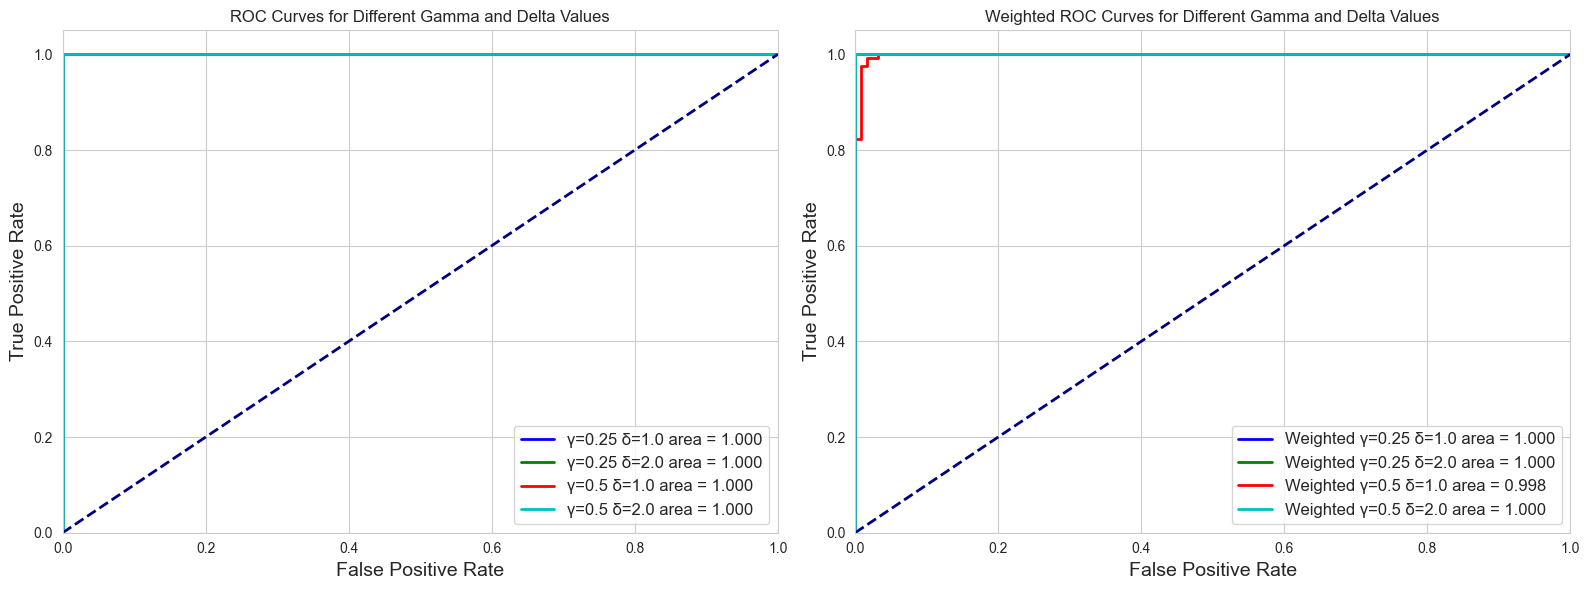

In [38]:
results = compute_roc_auc(
    ["california"],
    gamma_delta_pairs=gamma_delta_pairs,
    num_samples_per_class=125,
    num_tokens_per_sample=250,
    plot_distribution=True,
    softmax_temp=5.0,
    # linear_scale=0.85
)
# Plot all ROC curves
plot_roc_curves(results["non_weighted_results"], results["weighted_results"])

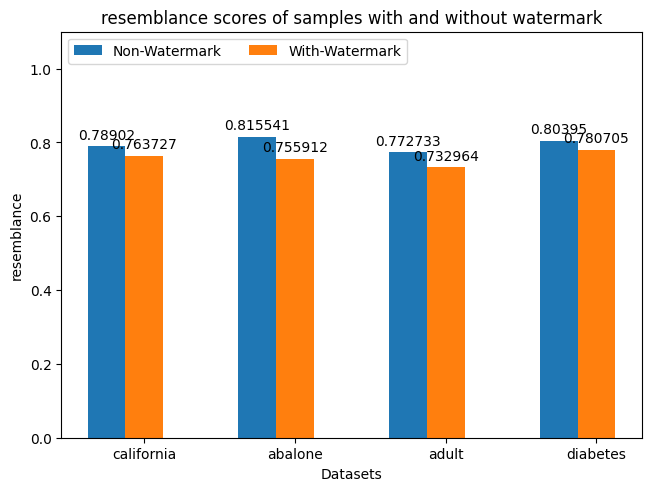

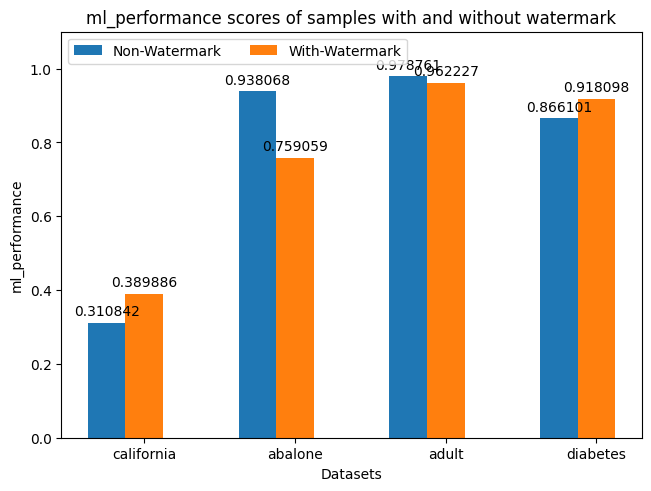

In [9]:
def plot_single_metric_between_model(model_names, metric_name, gamma, delta, sample_size=1000):

    non_watermark_scores = []
    with_watermark_scores = []
    for model_name in model_names:
        real_file_name, no_water_mark_file_name , with_water_mark_file_name = get_filenames_from_model(model_name, common_size=1000, gamma=0.25, delta=2.0)
        average_data_quality_result = average_data_quality(real_file_name, no_water_mark_file_name, with_water_mark_file_name, sample_size)
        non_watermark_scores.append(average_data_quality_result[metric_name]["No-Watermark"])
        with_watermark_scores.append(average_data_quality_result[metric_name]["With-Watermark"])
    
    scores = {
        "Non-Watermark": non_watermark_scores,
        "With-Watermark": with_watermark_scores
    }
            

    x = np.arange(len(model_names))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0    
    
    fig, ax = plt.subplots(layout='constrained')
    
    for attribute, measurement in scores.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(metric_name)
    ax.set_xlabel("Datasets")
    ax.set_title(f"{metric_name} scores of samples with and without watermark")
    ax.set_xticks(x + width, model_names)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 1.1)
    # plt.savefig(f"{metric_name}_between_datasets.png")
    plt.show()

plot_single_metric_between_model(model_names = ["california", "abalone", "adult", "diabetes"],
                                 metric_name="resemblance",
                                 gamma=0.25,
                                 delta=2.0,
                                 sample_size=1000)

plot_single_metric_between_model(model_names = ["california", "abalone", "adult", "diabetes"],
                                 metric_name="ml_performance",
                                 gamma=0.25,
                                 delta=2.0,
                                 sample_size=1000)

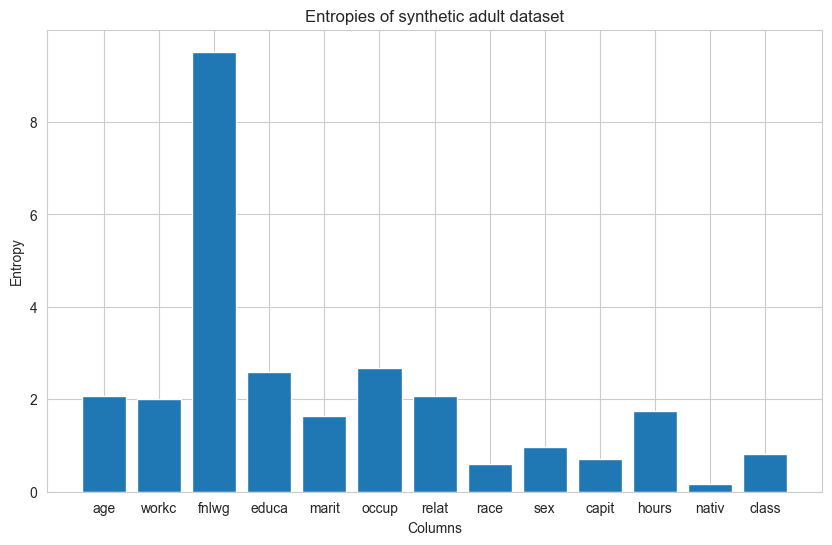

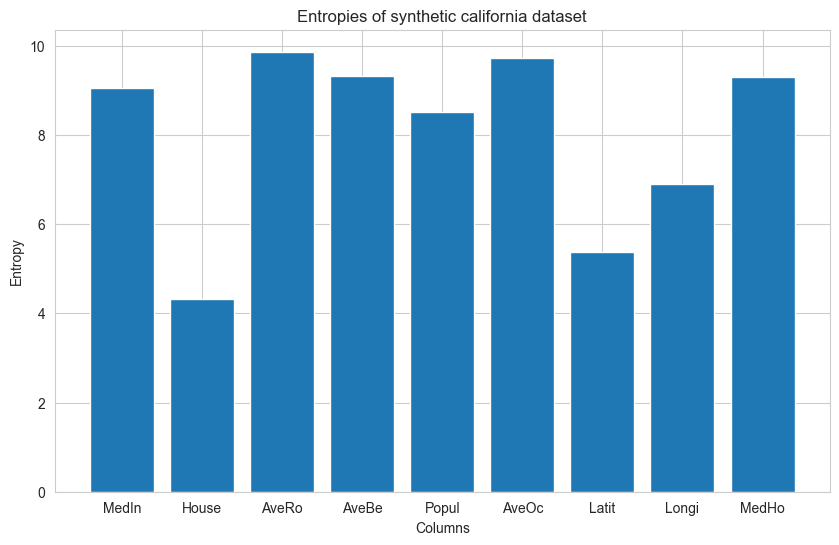

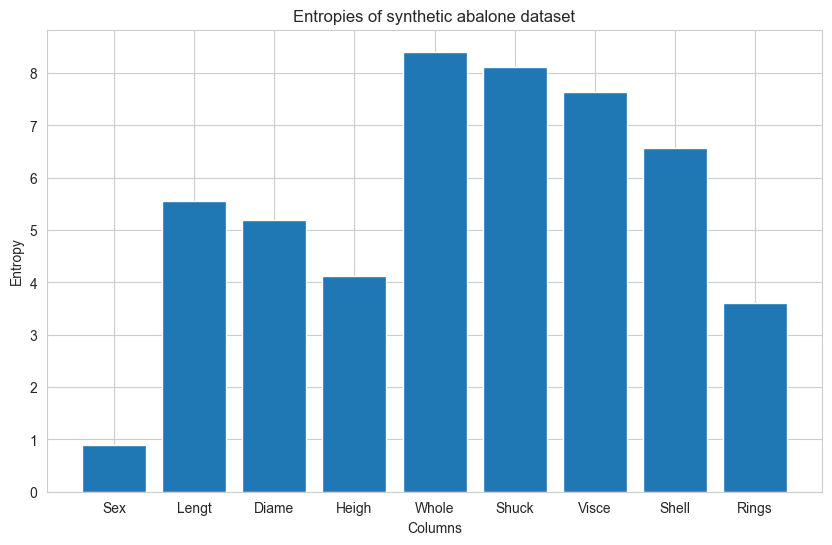

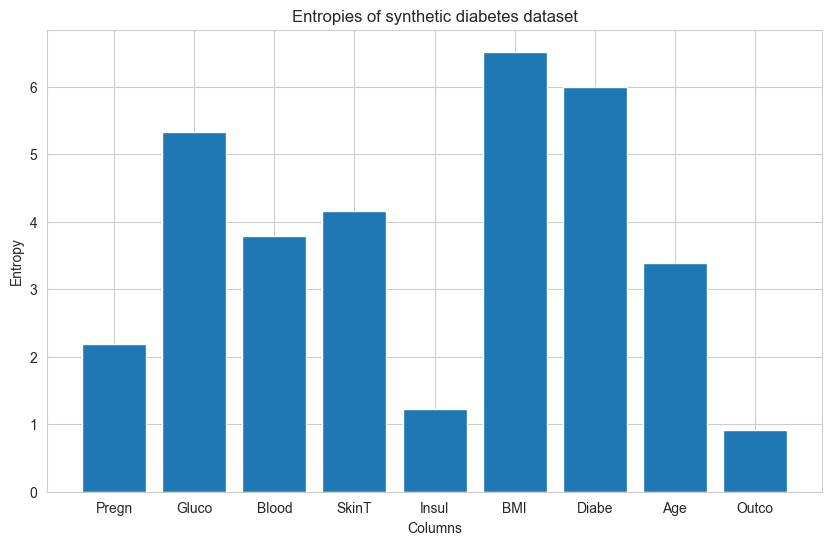

In [35]:
"""
Calculate entropy for each column in a df
"""
def table_entropy(df):
    entropies = {}
    for col_name in df.columns:
        if pd.api.types.is_numeric_dtype(df[col_name]):
            converted_col = pd.to_numeric(df[col_name], errors='coerce')
        else:
            converted_col = df[col_name].astype('category')
        
        value_counts = converted_col.value_counts()
    
        # Calculate probability for each value
        probabilities = value_counts / len(converted_col)
        
        # Calculate entropy
        entropies[col_name] = -np.sum(probabilities * np.log2(probabilities))
    
    return entropies

def plot_entropies(df, plot_name = None):
    entropies = table_entropy(df)

    shortened_labels = [col[:5] for col in entropies.keys()]
    
    plt.figure(figsize=(10, 6))
    plt.bar(shortened_labels, entropies.values())
    plt.xlabel('Columns')
    plt.ylabel('Entropy')
    plt.title(plot_name if plot_name else 'Entropy of each column in the dataset')
    plt.show()
    
def plot_alo(alo, plot_name = None):
    entropies = alo

    shortened_labels = [col[:5] for col in entropies.keys()]
    
    plt.figure(figsize=(10, 6))
    plt.bar(shortened_labels, entropies.values())
    plt.xlabel('Columns')
    plt.ylabel('Scaled Weights')
    plt.title(f'Scaled weights of {plot_name} dataset')
    plt.show()
    
def plot_entropies_by_model_name(model_name, gamma, delta, common_size):
    real, no_wa, with_wa = get_filenames_from_model(model_name, common_size, gamma, delta)
    
    samples_dir = "/Users/minhkau/Documents/TUDelft/Year 3/RP/Code/tabular-gpt/samples/"
    real_path = samples_dir + real
    # synth_no_watermark_path = samples_dir + no_wa
    synth_with_watermark_path = samples_dir + with_wa
    # 
    # plot_entropies(pd.read_csv(real_path), plot_name=f"Entropy of real {model_name} dataset")
    
    plot_entropies(pd.read_csv(synth_with_watermark_path), plot_name=f"Entropies of synthetic {model_name} dataset")
    
plot_entropies_by_model_name("adult", 0.5, 2.0, 1000)

plot_entropies_by_model_name("california", 0.5, 2.0, 1000)

plot_entropies_by_model_name("abalone", 0.5, 2.0, 1000)

plot_entropies_by_model_name("diabetes", 0.5, 2.0, 1000)

In [32]:
aba = pd.read_csv("/Users/minhkau/Documents/TUDelft/Year 3/RP/Code/tabular-gpt/samples/diabetes_original.csv")
for col in aba.columns:
    aba[col] = aba[col] * 1.0

aba.to_csv("fuckall.csv", index=False)